In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from PIL import Image
from typing import List
import torch
import torch.nn.functional as F
import torchvision
from tqdm import tqdm
from torchsummary import summary
from sklearn.manifold import TSNE
import math
import time
np.random.seed(42)
torch.manual_seed(42)
%matplotlib inline

In [4]:
# Hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 25

In [5]:
# GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1

## Load data

In [ ]:
# Load dataset

# These values are taken from the github: https://github.com/facebookarchive/fb.resnet.torch/issues/180
preprocessor = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])

transform_back = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(mean=[-0.4914/0.2470, -0.4822/0.2435, -0.4465/0.2616], std=[1/0.2470, 1/0.2435, 1/0.2616]),
    torchvision.transforms.ToPILImage()
])

cifar_10_data = torchvision.datasets.CIFAR10(root='./cifar_10', download=True, transform=preprocessor)
cifar_10_data

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar_10
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616])
           )

In [5]:
[(cifar_10_data.class_to_idx[clas], clas) for clas in cifar_10_data.classes]

[(0, 'airplane'),
 (1, 'automobile'),
 (2, 'bird'),
 (3, 'cat'),
 (4, 'deer'),
 (5, 'dog'),
 (6, 'frog'),
 (7, 'horse'),
 (8, 'ship'),
 (9, 'truck')]

In [6]:
# Split the data in 70:10:20 ratio for training, validation and testing
train_size = int(0.7 * len(cifar_10_data))
val_size = int(0.1 * len(cifar_10_data))
test_size = len(cifar_10_data) - train_size - val_size

train_data, val_data, test_data = torch.utils.data.random_split(cifar_10_data,
                                                                [train_size, val_size, test_size])

print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")

Train data size: 35000
Validation data size: 5000
Test data size: 10000


In [7]:
# Data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
for imgs, labs in train_loader:
    print(imgs.shape)
    print(labs.shape)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [ ]:
def viz_bottleneck_tsne(model, dataloader, model_type):
    """
    Use tSNE to visualize the bottleneck feature
    """
    # Pick a random batch
    imgs, labs = next(iter(dataloader))
    imgs = imgs.to(device)

    # Get the bottleneck features
    with torch.no_grad():
        if model_type == 'alexnet':
            bottleneck_features = model.features(imgs) # Through convolutional layers
            bottleneck_features = bottleneck_features.view(bottleneck_features.size(0), -1) # Flatten
            bottleneck_features = model.classifier[:6](bottleneck_features) # Up to the second last layer
        else: # resnet
            bottleneck_features = model.conv1(imgs)
            bottleneck_features = model.layer1(bottleneck_features)
            bottleneck_features = model.layer2(bottleneck_features)
            bottleneck_features = model.layer3(bottleneck_features)
            bottleneck_features = model.layer4(bottleneck_features)
            bottleneck_features = model.avgpool(bottleneck_features)
            bottleneck_features = torch.flatten(bottleneck_features, 1)

    # Convert the bottleneck features to numpy
    bottleneck_features = bottleneck_features.cpu().numpy()
    labs = labs.numpy()

    # Use tSNE to reduce the dimensionality
    tsne = TSNE(n_components=2, random_state=42)
    bottleneck_features = tsne.fit_transform(bottleneck_features)

    # Plot the tSNE reduced features
    plt.figure(figsize=(8, 8))
    for i in range(10):
        plt.scatter(bottleneck_features[labs == i, 0], bottleneck_features[labs == i, 1], label=i)
    plt.legend()
    plt.show()

In [10]:
def classifier_accuracy(model, dataloader):
    """
    Calculate the accuracy of the model on the given dataloader
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labs in dataloader:
            imgs, labs = imgs.to(device), labs.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            total += labs.size(0)
            correct += (predicted == labs).sum().item()
    return correct / total

## Train AlexNet

In [11]:
# Load the AlexNet model with random weights
alex_net = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)

Using cache found in /export/home/co21btech11001/.cache/torch/hub/pytorch_vision_v0.10.0
/export/home/co21btech11001/.conda/envs/nlp_new/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/export/home/co21btech11001/.conda/envs/nlp_new/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
# Move the model to GPU
alex_net.to(device)

summary(alex_net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

**Note:** AlexNet has around 61 million parameters

In [13]:
print(alex_net.features)
print(alex_net.classifier)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True

In [14]:
# Change last layer of the model so that it output 10 classes
alex_net.classifier[6] = torch.nn.Linear(4096, 10).to(device)

In [15]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs, model_type):
    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        model.train()
        batch_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = loss_fn(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            batch_loss += loss.item()

        train_loss.append(batch_loss / len(train_loader))

        # Validation loss
        model.eval()

        with torch.no_grad():
            val_batch_loss = 0.0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, labels)

                val_batch_loss += loss.item()

            val_loss.append(val_batch_loss / len(val_loader))

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}")

        # Visualize the bottleneck features at the end of first epoch
        if epoch == 0:
            print("\nVisualizing bottleneck features")
            viz_bottleneck_tsne(model, train_loader, model_type)

        # Early stopping if validation loss starts increasing
        if epoch > 0 and val_loss[-1] > val_loss[-2]:
            print("Validation loss is increasing, stopping the training")
            break
        else:
            # Shuffle the data
            train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    
    print("Training completed")
    # Visualize bottleneck features at the end of training
    print("\nVisualizing bottleneck features")
    viz_bottleneck_tsne(model, train_loader, model_type)

    return train_loss, val_loss

In [16]:
# Loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alex_net.parameters(), lr=LEARNING_RATE)

Epoch 1/25: 100%|██████████| 547/547 [01:03<00:00,  8.63it/s]


Epoch 1/25, Train Loss: 1.8778, Val Loss: 1.4956

Visualizing bottleneck features


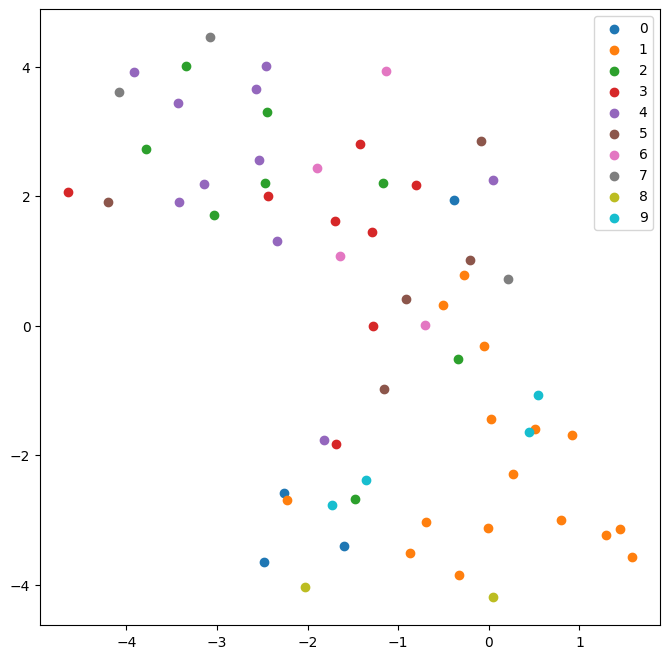

Epoch 2/25: 100%|██████████| 547/547 [01:01<00:00,  8.86it/s]


Epoch 2/25, Train Loss: 1.4891, Val Loss: 1.3339


Epoch 3/25: 100%|██████████| 547/547 [01:03<00:00,  8.68it/s]


Epoch 3/25, Train Loss: 1.3579, Val Loss: 1.2320


Epoch 4/25: 100%|██████████| 547/547 [01:01<00:00,  8.89it/s]


Epoch 4/25, Train Loss: 1.2661, Val Loss: 1.2055


Epoch 5/25: 100%|██████████| 547/547 [01:02<00:00,  8.80it/s]


Epoch 5/25, Train Loss: 1.1736, Val Loss: 1.1944


Epoch 6/25: 100%|██████████| 547/547 [01:01<00:00,  8.88it/s]


Epoch 6/25, Train Loss: 1.1175, Val Loss: 1.0727


Epoch 7/25: 100%|██████████| 547/547 [01:01<00:00,  8.85it/s]


Epoch 7/25, Train Loss: 1.0614, Val Loss: 1.0347


Epoch 8/25: 100%|██████████| 547/547 [01:01<00:00,  8.87it/s]


Epoch 8/25, Train Loss: 0.9958, Val Loss: 1.0041


Epoch 9/25: 100%|██████████| 547/547 [01:01<00:00,  8.84it/s]


Epoch 9/25, Train Loss: 0.9710, Val Loss: 1.0243
Validation loss is increasing, stopping the training
Training completed

Visualizing bottleneck features


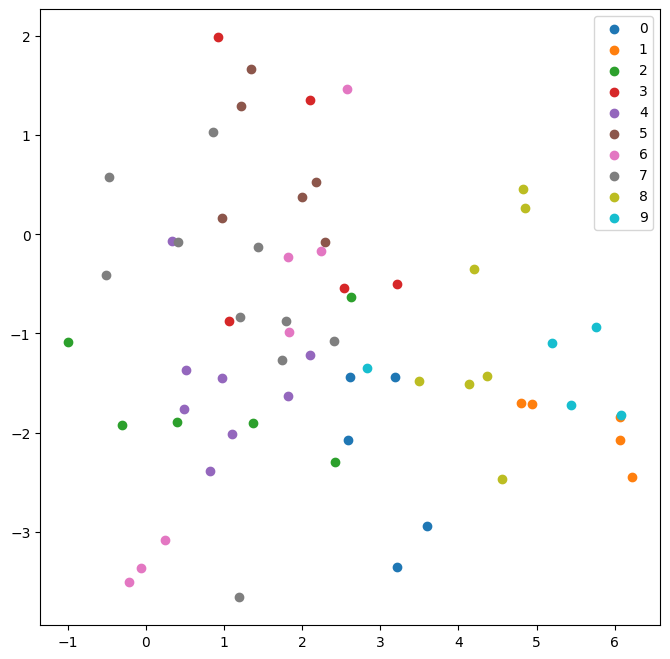

In [17]:
train_loss, val_loss = train_model(alex_net, train_loader, val_loader, loss_fn, optimizer, EPOCHS,
                                   model_type='alexnet')

In [18]:
# Save the model
torch.save(alex_net.state_dict(), "alexnet_cifar10.pth")

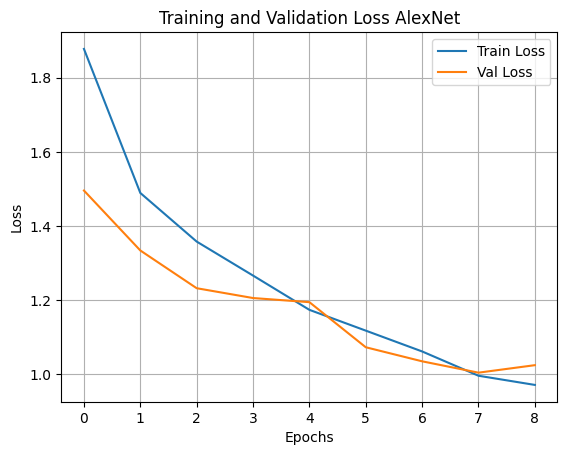

In [19]:
# Plot the training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss AlexNet')
plt.legend()
plt.grid()
plt.show()

In [22]:
# Accuracy of the classifier
train_accuracy = classifier_accuracy(alex_net, train_loader)
val_accuracy = classifier_accuracy(alex_net, val_loader)
test_accuracy = classifier_accuracy(alex_net, test_loader)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.7322
Validation Accuracy: 0.6408
Test Accuracy: 0.6427


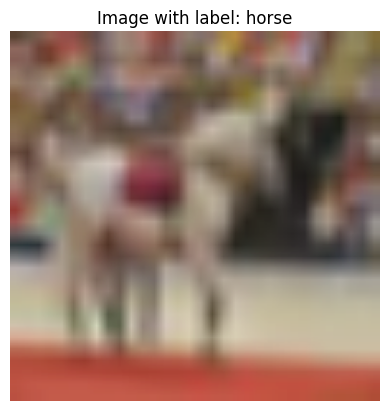

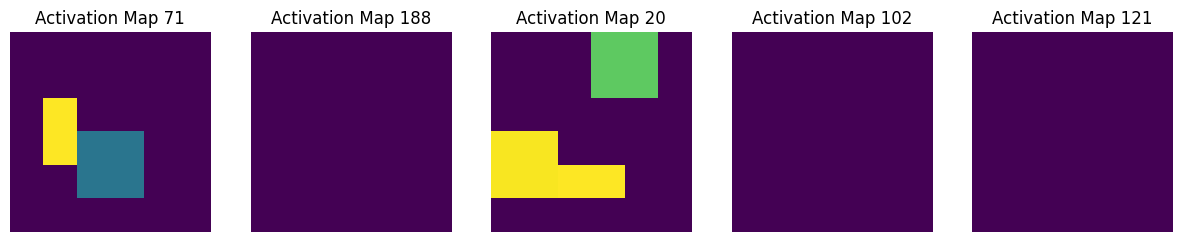

In [ ]:
# Visualize activation maps

# Pick an image from the test set
img, lab = next(iter(test_loader))
img = img[0].unsqueeze(0).to(device)
lab = lab[0].item()

# Plot the image
plt.imshow(transform_back(img.cpu().squeeze()))
plt.title("Image with label: " + cifar_10_data.classes[lab])
plt.axis('off')
plt.show()

# Get the activation maps
with torch.no_grad():
    activation_map = alex_net.features(img) # Shape = [1, 256, 6, 6]

# Plot 5 random activation maps
plt.figure(figsize=(15, 10))
random_indices = np.random.randint(0, 256, 5)
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(activation_map[0, idx].cpu(), cmap='viridis')
    plt.axis('off')
    plt.title(f"Activation Map {idx}")
plt.show()

## Train ResNet50

In [20]:
resnet_50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)

Using cache found in /export/home/co21btech11001/.cache/torch/hub/pytorch_vision_v0.10.0
/export/home/co21btech11001/.conda/envs/nlp_new/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/export/home/co21btech11001/.conda/envs/nlp_new/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [21]:
resnet_50.to(device)
summary(resnet_50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

**Note:** ResNet50 has around 25 million parameters

In [24]:
print(resnet_50.conv1)
print(resnet_50.layer1)
print(resnet_50.layer2)
print(resnet_50.layer3)
print(resnet_50.layer4)
print(resnet_50.fc)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, moment

In [25]:
# Change the last layer of the model so that it output 10 classes
resnet_50.fc = torch.nn.Linear(2048, 10).to(device)

In [26]:
# Loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_50.parameters(), lr=LEARNING_RATE)

Epoch 1/25: 100%|██████████| 547/547 [03:26<00:00,  2.65it/s]


Epoch 1/25, Train Loss: 1.7560, Val Loss: 1.5244

Visualizing bottleneck features


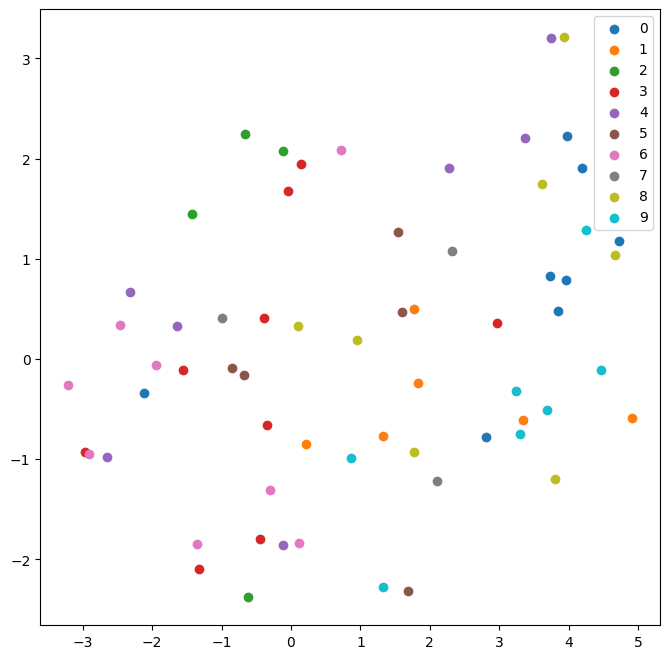

Epoch 2/25: 100%|██████████| 547/547 [03:29<00:00,  2.61it/s]


Epoch 2/25, Train Loss: 1.2367, Val Loss: 1.2220


Epoch 3/25: 100%|██████████| 547/547 [03:28<00:00,  2.62it/s]


Epoch 3/25, Train Loss: 0.9561, Val Loss: 1.0107


Epoch 4/25: 100%|██████████| 547/547 [03:26<00:00,  2.65it/s]


Epoch 4/25, Train Loss: 0.7926, Val Loss: 0.8096


Epoch 5/25: 100%|██████████| 547/547 [03:26<00:00,  2.65it/s]


Epoch 5/25, Train Loss: 0.6764, Val Loss: 0.6704


Epoch 6/25: 100%|██████████| 547/547 [03:26<00:00,  2.65it/s]


Epoch 6/25, Train Loss: 0.5761, Val Loss: 0.7618
Validation loss is increasing, stopping the training
Training completed

Visualizing bottleneck features


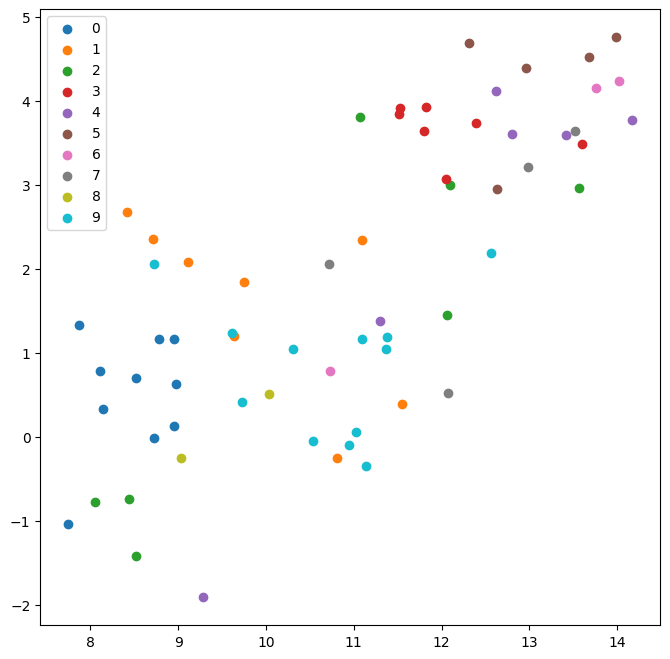

In [27]:
train_loss, val_loss = train_model(resnet_50, train_loader, val_loader, loss_fn, optimizer, EPOCHS,
                                   model_type='resnet50')

In [28]:
# Save the model
torch.save(resnet_50.state_dict(), "resnet50_cifar10.pth")

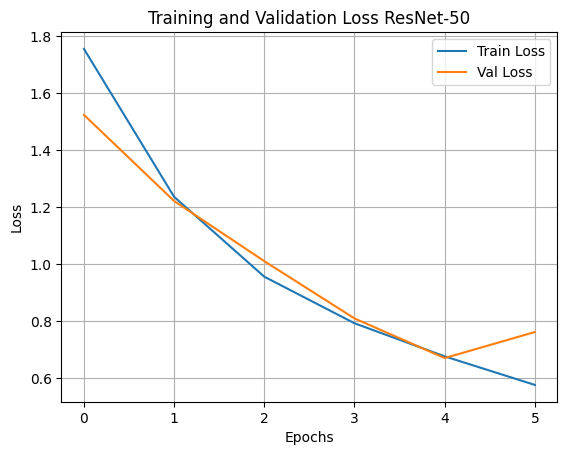

In [29]:
# Plot the training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss ResNet-50')
plt.legend()
plt.grid()
plt.show()

In [30]:
# Accuracy of the classifier
train_accuracy = classifier_accuracy(resnet_50, train_loader)
val_accuracy = classifier_accuracy(resnet_50, val_loader)
test_accuracy = classifier_accuracy(resnet_50, test_loader)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.7989
Validation Accuracy: 0.7464
Test Accuracy: 0.7447


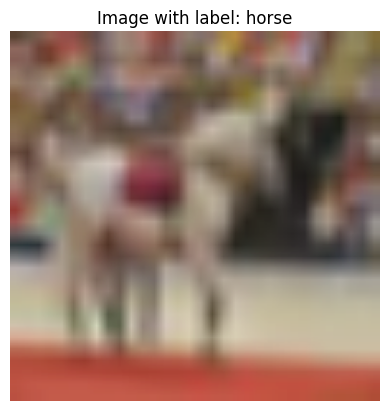

torch.Size([1, 2048, 14, 14])


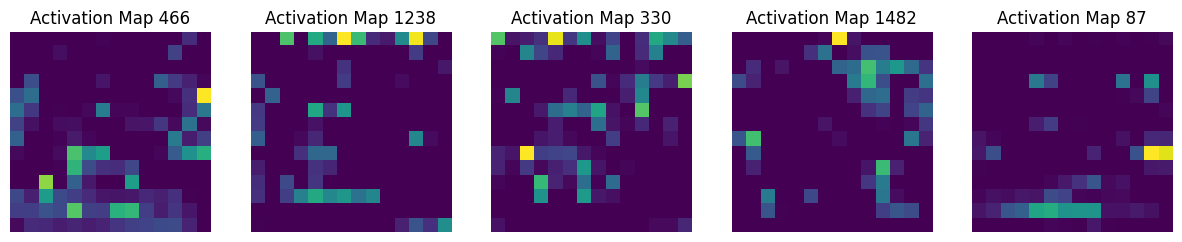

In [40]:
#  Plot activation maps

# Pick an image from the test set
img, lab = next(iter(test_loader))
img = img[0].unsqueeze(0).to(device)
lab = lab[0].item()

# Plot the image
plt.imshow(transform_back(img.cpu().squeeze()))
plt.title("Image with label: " + cifar_10_data.classes[lab])
plt.axis('off')
plt.show()

# Get the activation maps
with torch.no_grad():
    activation_map = resnet_50.conv1(img)
    activation_map = resnet_50.layer1(activation_map)
    activation_map = resnet_50.layer2(activation_map)
    activation_map = resnet_50.layer3(activation_map)
    activation_map = resnet_50.layer4(activation_map) # Shape = [1, 2048, 14, 14]

    print(activation_map.shape)

# Plot 5 random activation maps
plt.figure(figsize=(15, 10))
random_indices = np.random.randint(0, 2048, 5)
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(activation_map[0, idx].cpu(), cmap='viridis')
    plt.axis('off')
    plt.title(f"Activation Map {idx}")
plt.show()

**Observations and Conclusions:**
| Model    | Train Accuracy | Val Accuracy | Test Accuracy | Time per Epoch |
|----------|----------------|--------------|---------------|----------------|
| AlexNet  | 73.32         | 64.08       | 64.27        | 1:00 minute    |
| ResNet50 | 79.89         | 74.64       | 74.47        | 3:30 minutes   |

1. `ResNet50` has fewer parameters than `AlexNet`
2. `ResNet50` takes 3:30 minutes per epoch to train, while `AlexNet` takes 1:00 minute per epoch to train
3. `ResNet50` has a higher accuracy than `AlexNet`

Therefore, considering the tradeoff between time taken to train and accuracy, `ResNet50` is a **better choice** than `AlexNet`.

In [ ]:
# Free up cuda memory
torch.cuda.empty_cache()

# 2

## RNN tutorial replicated

In [6]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Arabic.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/Chinese.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']
Slusarski


In [7]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [8]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [9]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [10]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-3.0014, -2.8677, -2.9758, -2.9196, -3.1387, -2.8728, -2.8886, -2.8754,
         -2.5694, -2.8957, -2.8363, -2.9602, -2.9206, -2.8656, -2.8350, -2.7372,
         -3.0470, -2.9479]], grad_fn=<LogSoftmaxBackward0>)


In [11]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Irish', 8)


In [12]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = French / line = Tasse
category = Chinese / line = Sum
category = Polish / line = Andrysiak
category = Chinese / line = Yau
category = Dutch / line = Roosevelt
category = Chinese / line = Chin
category = Czech / line = Kudrna
category = Dutch / line = Snell
category = Czech / line = Cerny
category = Scottish / line = Smith


In [13]:
criterion = nn.NLLLoss()

In [14]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [13]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 13s) 2.1886 Taguchi / Italian ✗ (Japanese)
10000 10% (0m 27s) 1.6885 Ma / Vietnamese ✗ (Korean)
15000 15% (0m 41s) 1.8898 San / Chinese ✗ (Korean)
20000 20% (0m 54s) 2.7527 Peerenboom / Scottish ✗ (Dutch)
25000 25% (1m 8s) 1.0529 Bitar / Arabic ✓
30000 30% (1m 22s) 0.2475 Missiakos / Greek ✓
35000 35% (1m 35s) 2.5404 Araya / Japanese ✗ (Spanish)
40000 40% (1m 49s) 0.2693 Quyen / Vietnamese ✓
45000 45% (2m 2s) 0.2843 Jaskulski / Polish ✓
50000 50% (2m 16s) 0.3746 Reagan / Irish ✓
55000 55% (2m 30s) 0.9943 Bukowski / Polish ✓
60000 60% (2m 44s) 2.4787 Tracey / French ✗ (Irish)
65000 65% (2m 57s) 1.2542 Zhen / Korean ✗ (Chinese)
70000 70% (3m 11s) 1.5578 Desjardins / French ✓
75000 75% (3m 24s) 2.8918 Vaisfeld / English ✗ (Russian)
80000 80% (3m 38s) 2.0615 Laar / German ✗ (Dutch)
85000 85% (3m 51s) 0.1622 Shamon / Arabic ✓
90000 90% (4m 5s) 2.0016 Palmer / German ✗ (English)
95000 95% (4m 19s) 1.8264 Macias / French ✗ (Spanish)
100000 100% (4m 32s) 1.0453 Lilley / English ✓


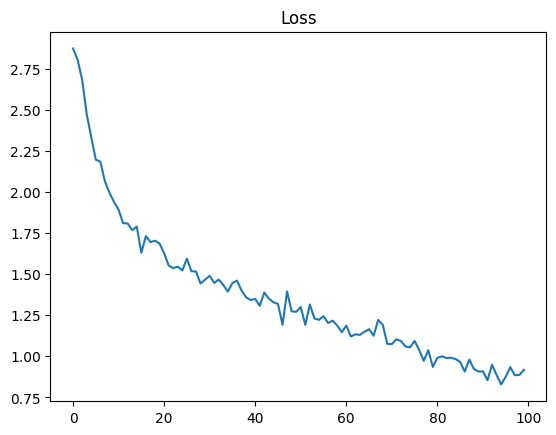

In [14]:
plt.figure()
plt.plot(all_losses)
plt.title('Loss')
plt.show()

Accuracy: 69.1831%


/tmp/ipykernel_769380/751506345.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_769380/751506345.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


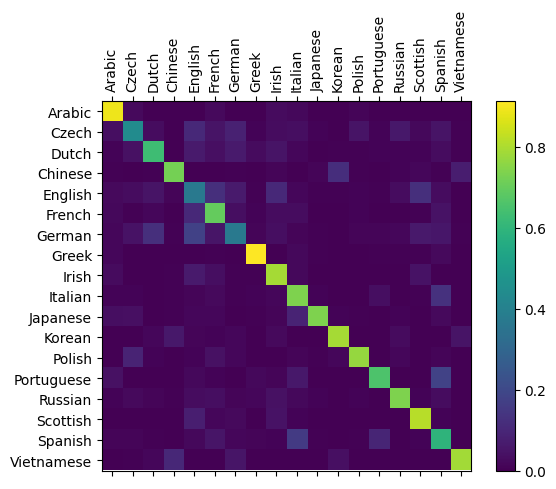

In [15]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Print accuracy
accuracy = sum([confusion[i][i] for i in range(n_categories)])
accuracy = accuracy.item() / n_categories
print(f"Accuracy: {accuracy*100:.4f}%")

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [16]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.44) Russian
(-1.88) Czech
(-2.18) Irish

> Jackson
(-0.93) English
(-1.23) Russian
(-1.91) Scottish

> Satoshi
(-0.31) Japanese
(-2.21) Arabic
(-3.18) Russian


## Replace RNN with GRU

In [ ]:
class GRU_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU_Model, self).__init__()

        self.hidden_size = hidden_size

        self.gru = nn.GRU(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        # Take the hidden state and pass it through the linear layer
        output = self.h2o(hidden[0])
        output = self.softmax(output)
        return output

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)
    
n_hidden = 128
gru_model = GRU_Model(n_letters, n_hidden, n_categories)

In [20]:
input = lineToTensor('Albert')
print(input.shape)
hidden = torch.zeros(1, 1, n_hidden)
output = gru_model(input, hidden)

print(output.shape)

torch.Size([6, 1, 57])
torch.Size([1, 18])


In [21]:
criterion = nn.NLLLoss()

In [22]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train_gru(category_tensor, line_tensor):
    hidden = gru_model.initHidden()

    gru_model.zero_grad()

    output = gru_model(line_tensor, hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in gru_model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [23]:
n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_gru(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 17s) 2.5307 Protopsaltis / Greek ✓
10000 10% (0m 36s) 2.9277 Ino / Russian ✗ (Japanese)
15000 15% (0m 53s) 2.5818 Pae / Korean ✓
20000 20% (1m 11s) 1.9790 Ribeiro / Portuguese ✓
25000 25% (1m 28s) 1.8847 Freud / German ✓
30000 30% (1m 46s) 2.1477 Bartosz / Polish ✓
35000 35% (2m 4s) 2.4079 Szewc / Czech ✗ (Polish)
40000 40% (2m 21s) 1.1330 Tsunoda / Japanese ✓
45000 45% (2m 39s) 0.5734 Shalhoub / Arabic ✓
50000 50% (2m 57s) 2.8450 Leblanc / Irish ✗ (French)
55000 55% (3m 14s) 1.8717 Aller / German ✗ (Dutch)
60000 60% (3m 32s) 3.1898 Krause / Japanese ✗ (German)
65000 65% (3m 49s) 0.9308 Meeuwissen / Dutch ✓
70000 70% (4m 7s) 0.1865 Thach / Vietnamese ✓
75000 75% (4m 24s) 0.0949 Traversi / Italian ✓
80000 80% (4m 42s) 0.3574 Cablikova / Czech ✓
85000 85% (5m 0s) 0.1104 Arihyoshi / Japanese ✓
90000 90% (5m 17s) 0.5550 Laurent / French ✓
95000 95% (5m 35s) 2.1633 Matano / Italian ✗ (Japanese)
100000 100% (5m 52s) 3.3808 Antic / Czech ✗ (English)


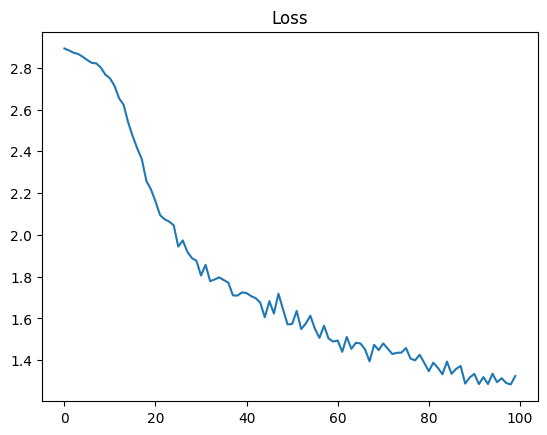

In [24]:
plt.figure()
plt.plot(all_losses)
plt.title('Loss')
plt.show()

Accuracy: 56.5927%


/tmp/ipykernel_3604352/125060781.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_3604352/125060781.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


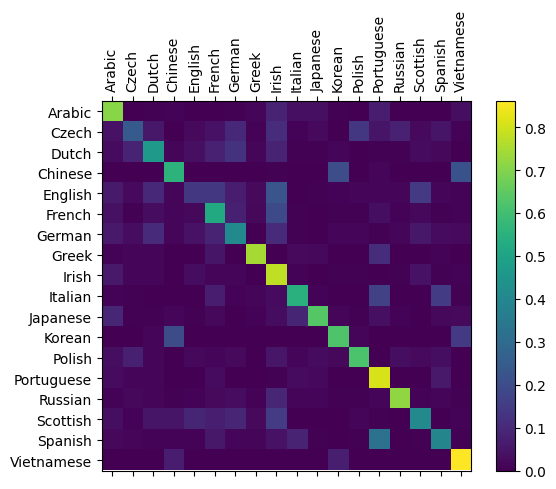

In [25]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = gru_model.initHidden()

    output = gru_model(line_tensor, hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Print accuracy
accuracy = sum([confusion[i][i] for i in range(n_categories)])
accuracy = accuracy.item() / n_categories
print(f"Accuracy: {accuracy*100:.4f}%")

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [26]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.48) Russian
(-1.82) Czech
(-2.54) English

> Jackson
(-0.33) Scottish
(-1.89) English
(-3.30) Polish

> Satoshi
(-0.76) Arabic
(-1.35) Italian
(-1.51) Japanese


## Replace GRU with LSTM

In [32]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_Model, self).__init__()

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        output, (next_hidden, cell) = self.lstm(input, (hidden, cell))
        # Take the hidden state and pass it through the linear layer
        output = self.h2o(next_hidden[0])
        output = self.softmax(output)
        return output
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size)
    
lstm_model = LSTM_Model(n_letters, n_hidden, n_categories)

In [34]:
input = lineToTensor('Albert')
print(input.shape)
hidden = torch.zeros(1, 1, n_hidden)
output = lstm_model(input, hidden, hidden)

print(output.shape)

torch.Size([6, 1, 57])
torch.Size([1, 18])


In [35]:
criterion = nn.NLLLoss()

In [36]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train_lstm(category_tensor, line_tensor):
    hidden, cell = lstm_model.initHidden()

    lstm_model.zero_grad()

    output = lstm_model(line_tensor, hidden, cell)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in lstm_model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [37]:
n_iters = 100000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_lstm(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 8s) 2.7405 Klein / Dutch ✓
10000 10% (0m 16s) 2.8606 Robert / German ✗ (French)
15000 15% (0m 25s) 2.9729 Pinter / German ✗ (Czech)
20000 20% (0m 33s) 2.9154 Fiore / French ✗ (Italian)
25000 25% (0m 41s) 2.8667 Maria / Japanese ✗ (Portuguese)
30000 30% (0m 50s) 1.3437 Sun / Chinese ✗ (Korean)
35000 35% (0m 58s) 2.7675 Szwarc / Arabic ✗ (Polish)
40000 40% (1m 6s) 0.1918 Malihoudis / Greek ✓
45000 45% (1m 15s) 1.0728 Chau / Vietnamese ✓
50000 50% (1m 23s) 0.8476 Mojartsev / Russian ✓
55000 55% (1m 31s) 1.0847 Totah / Arabic ✓
60000 60% (1m 40s) 1.1970 Sniders / Dutch ✓
65000 65% (1m 48s) 1.1256 Araullo / Spanish ✗ (Portuguese)
70000 70% (1m 56s) 5.2117 Santillian / Irish ✗ (Spanish)
75000 75% (2m 5s) 0.9071 Dresdner / German ✓
80000 80% (2m 13s) 1.7588 Deschamps / Dutch ✗ (French)
85000 85% (2m 21s) 3.2549 Persein / French ✗ (Czech)
90000 90% (2m 30s) 5.1469 Young / Vietnamese ✗ (Scottish)
95000 95% (2m 38s) 1.1371 Sayegh / Arabic ✓
100000 100% (2m 46s) 1.6565 Colman / Scotti

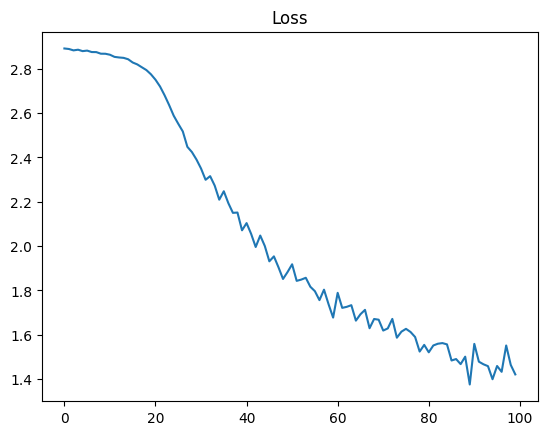

In [38]:
plt.figure()
plt.plot(all_losses)
plt.title('Loss')
plt.show()

Accuracy: 52.8267%


/tmp/ipykernel_3604352/3160434911.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_3604352/3160434911.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


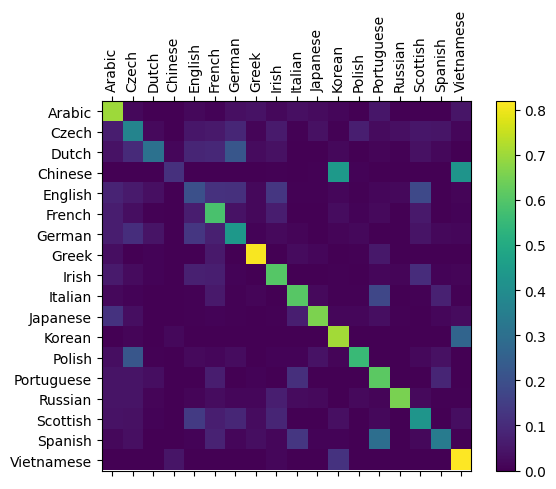

In [39]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden, cell = lstm_model.initHidden()

    output = lstm_model(line_tensor, hidden, cell)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Print accuracy
accuracy = sum([confusion[i][i] for i in range(n_categories)])
accuracy = accuracy.item() / n_categories
print(f"Accuracy: {accuracy*100:.4f}%")

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [40]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-1.03) Czech
(-1.60) Russian
(-2.02) English

> Jackson
(-0.37) Scottish
(-1.93) English
(-2.95) Czech

> Satoshi
(-0.81) Arabic
(-0.85) Japanese
(-2.38) Italian


**Observations and Conclusions:**

| Model | Accuracy |
|-------|----------|
| RNN   | 69.1831% |
| GRU   | 56.5927% |
| LSTM  | 52.8267% |

This is because the task of classifying the names is not complex enough to require the use of LSTM or GRU. RNN is sufficient for this task.<br>
However, the accuracy with GRU and LSTM can be increased by tuning the hyperparameters such as learning rate and number of epochs.